In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import base dataset
base = pd.read_csv("FinanceData/Base.csv")
# base.head()

In [3]:
base.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


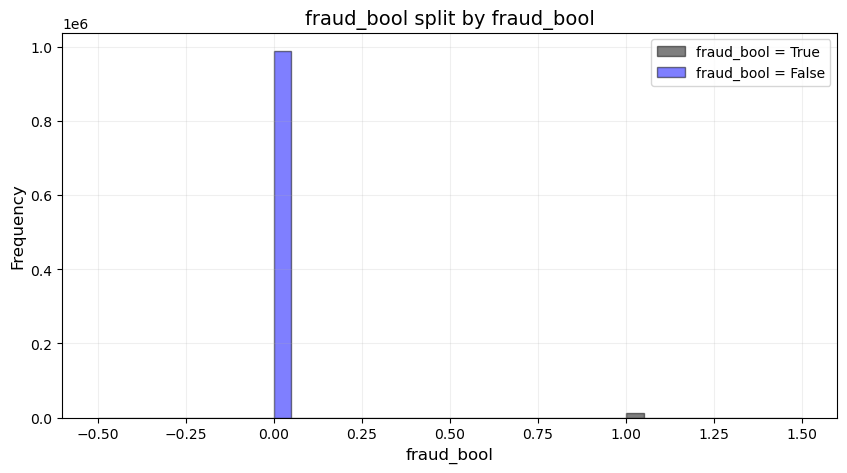

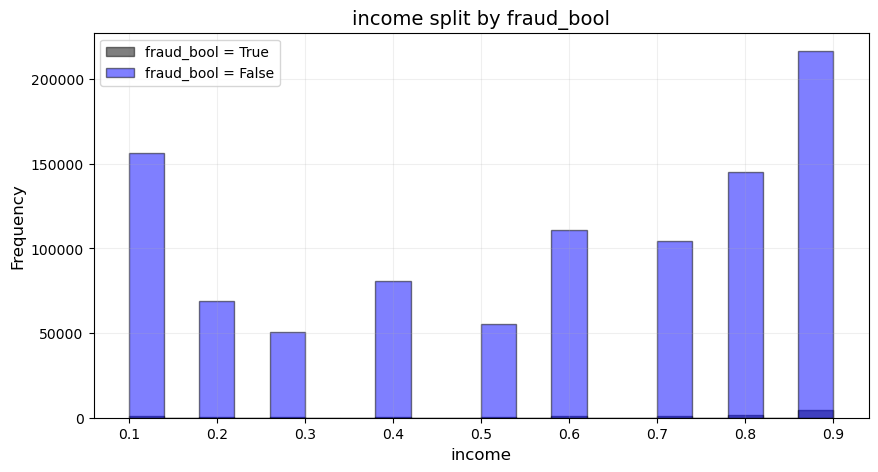

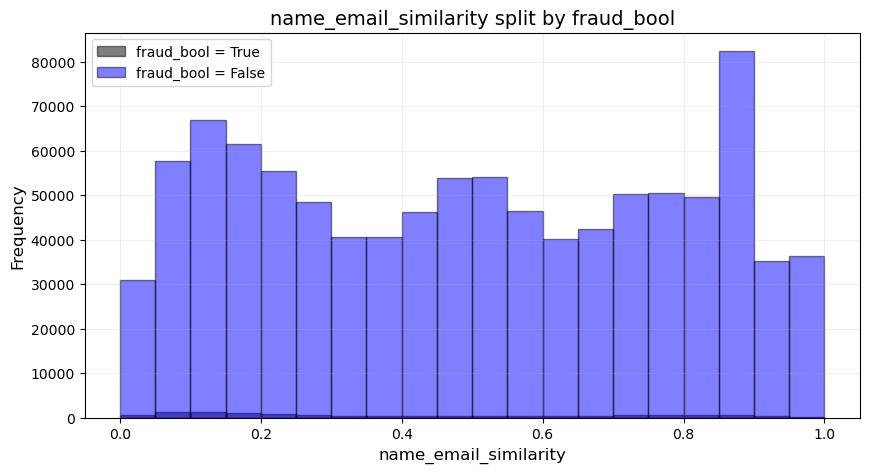

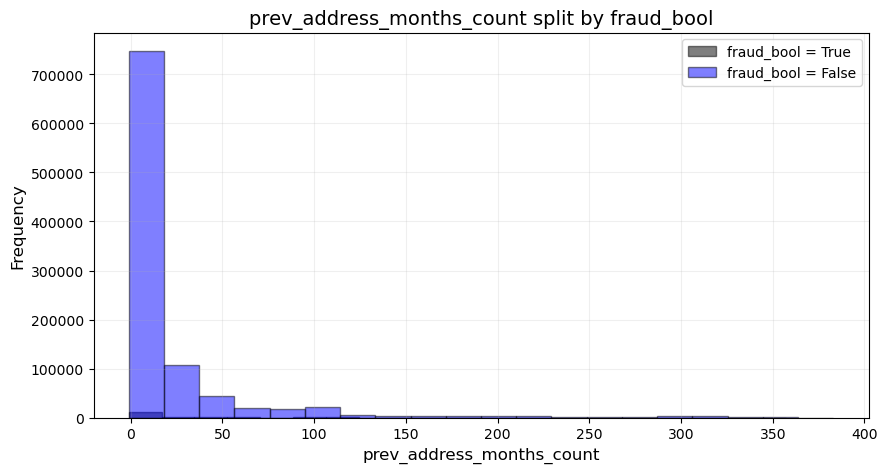

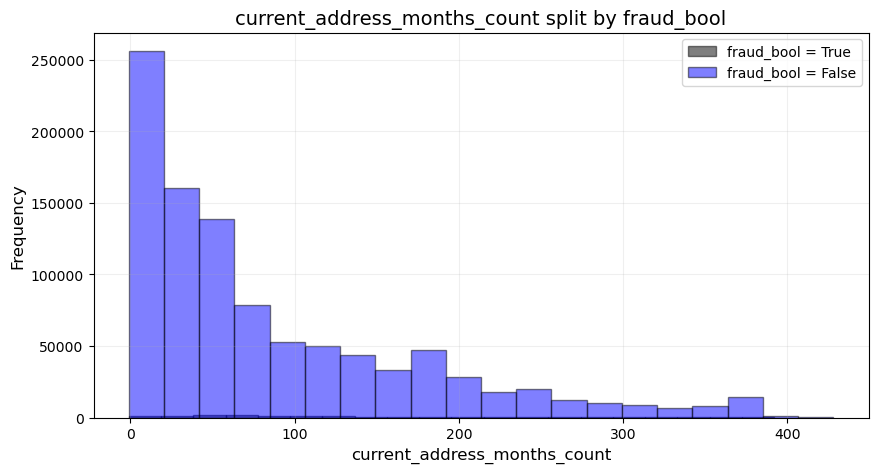

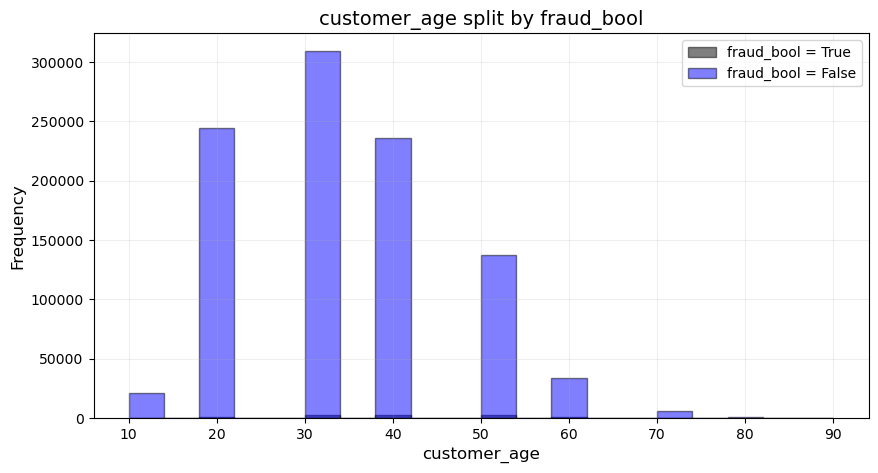

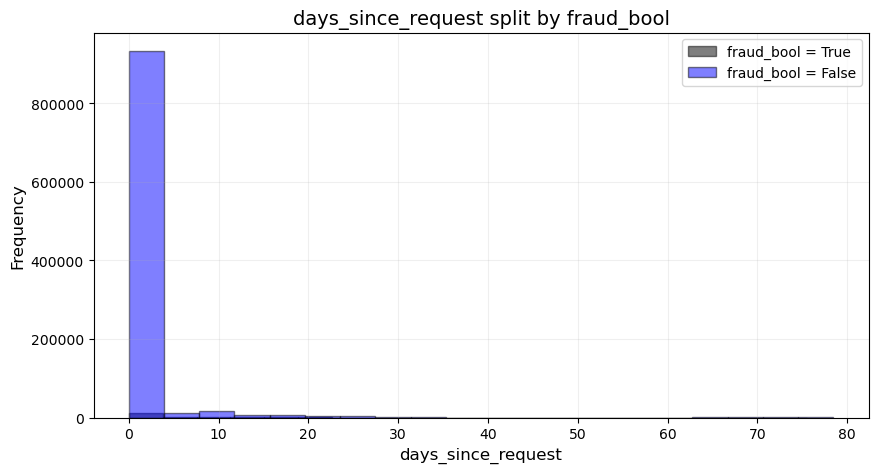

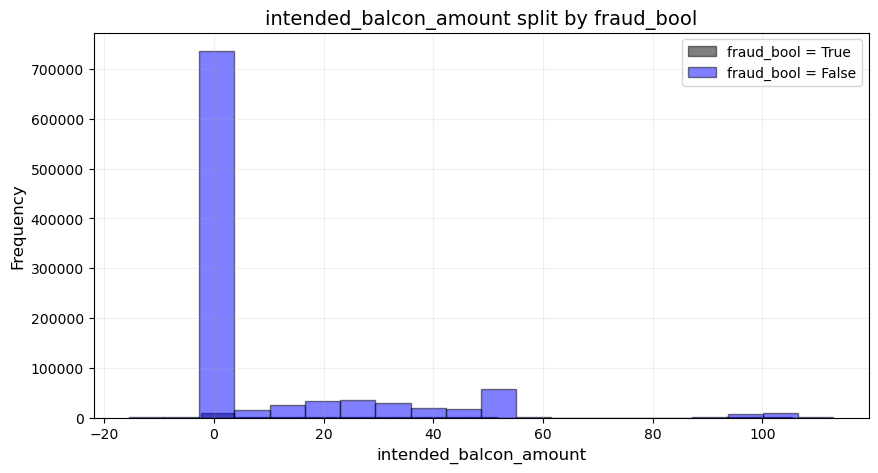

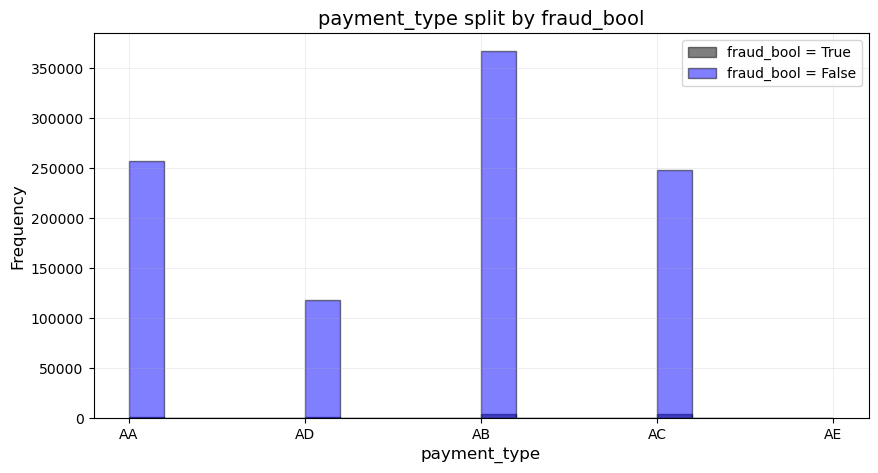

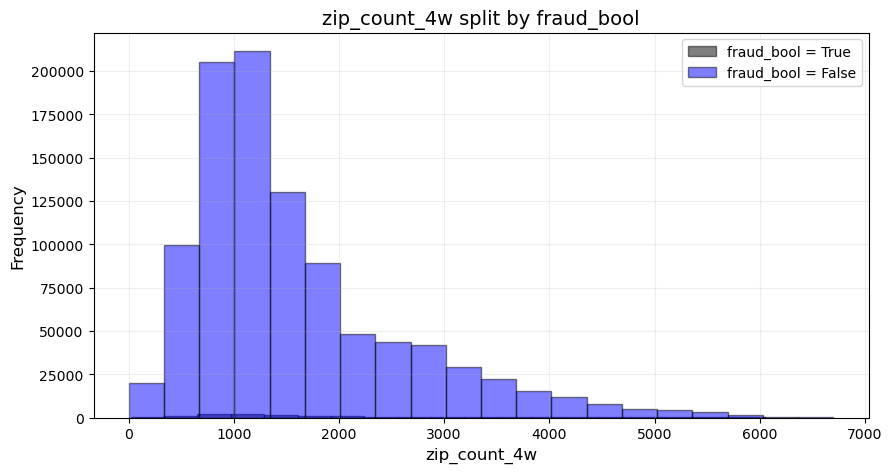

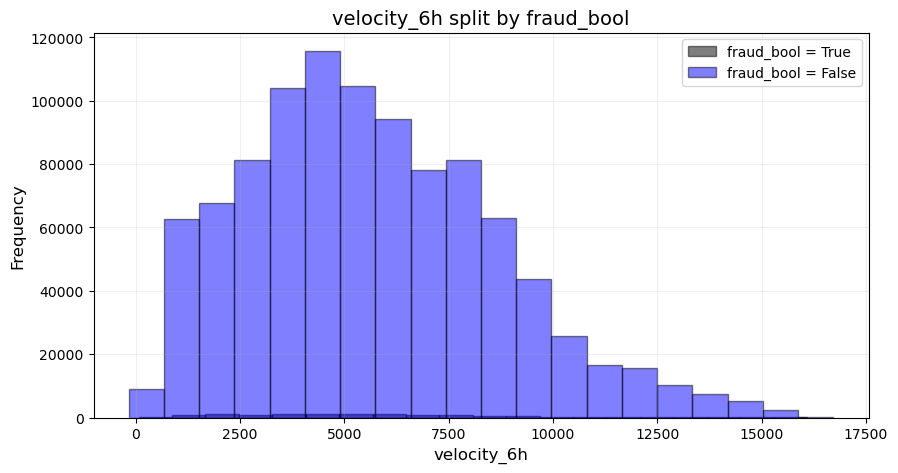

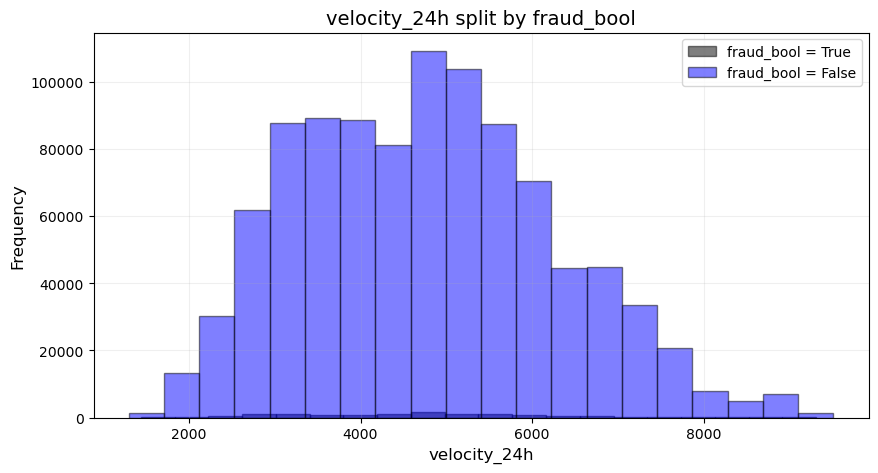

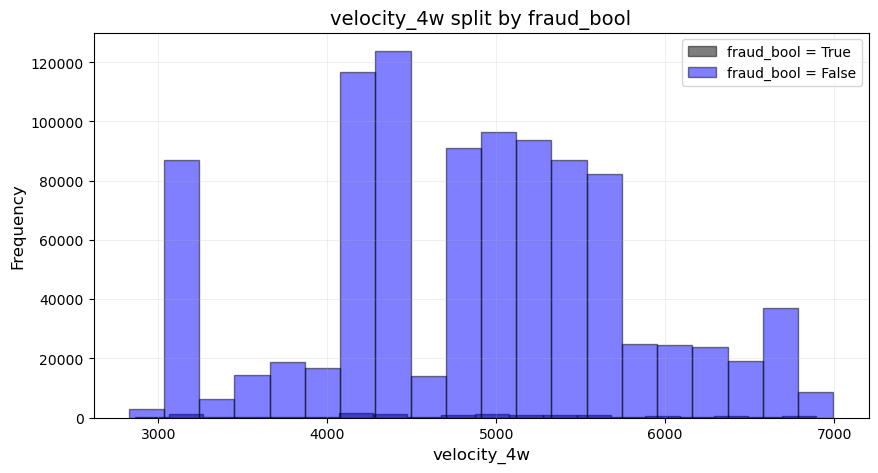

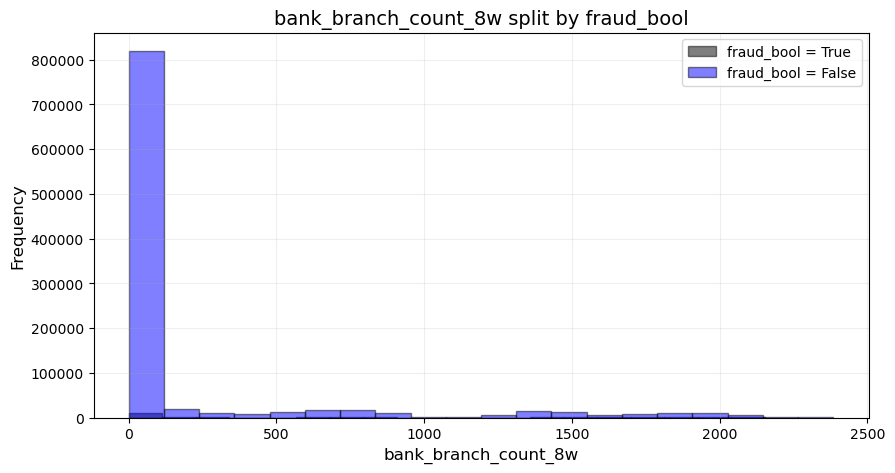

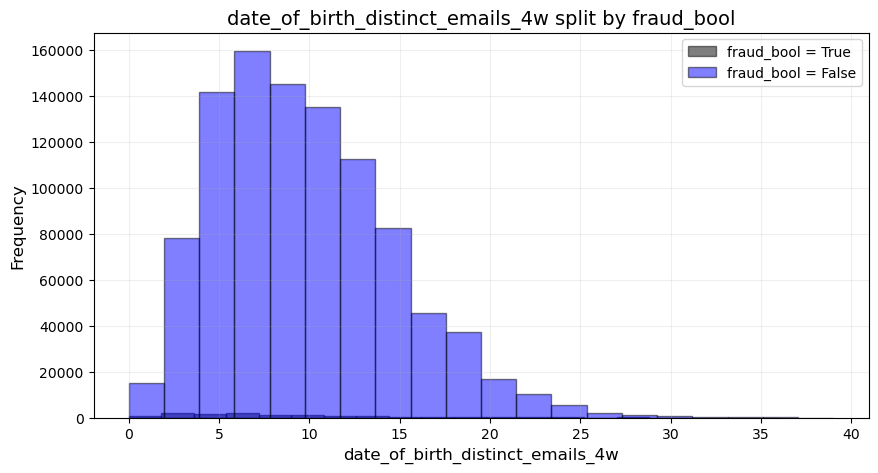

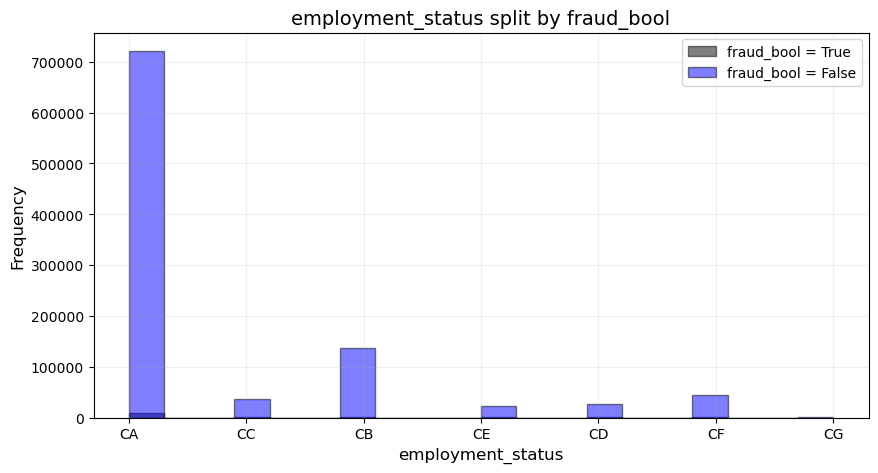

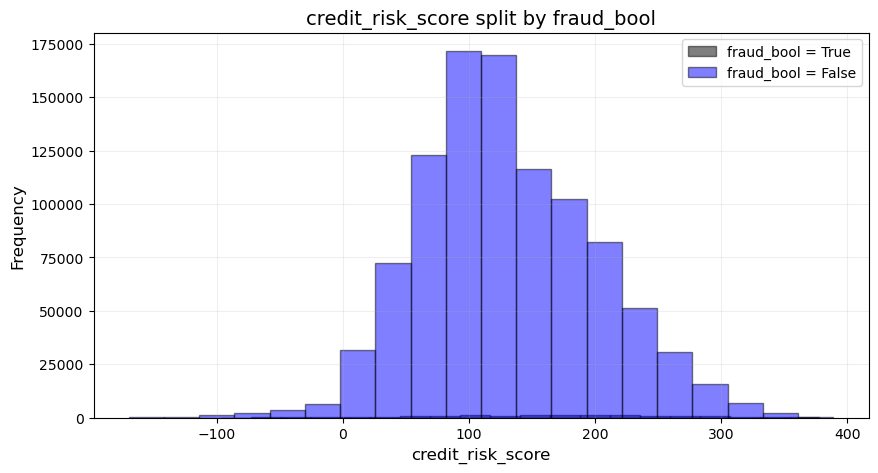

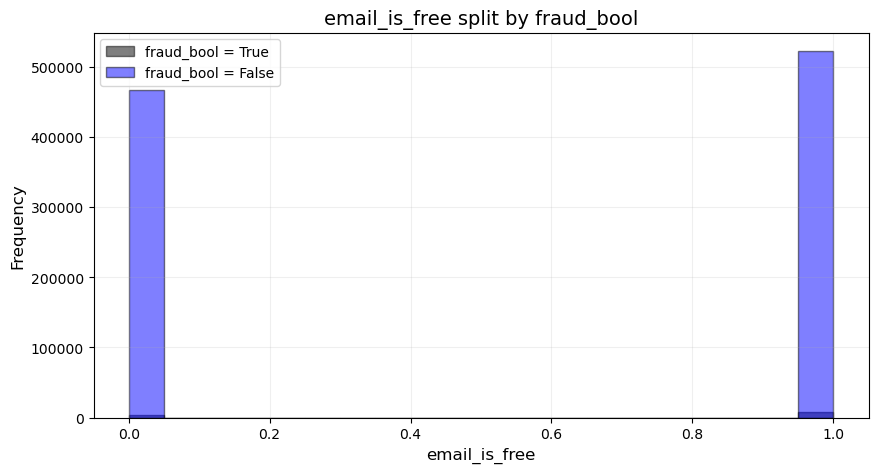

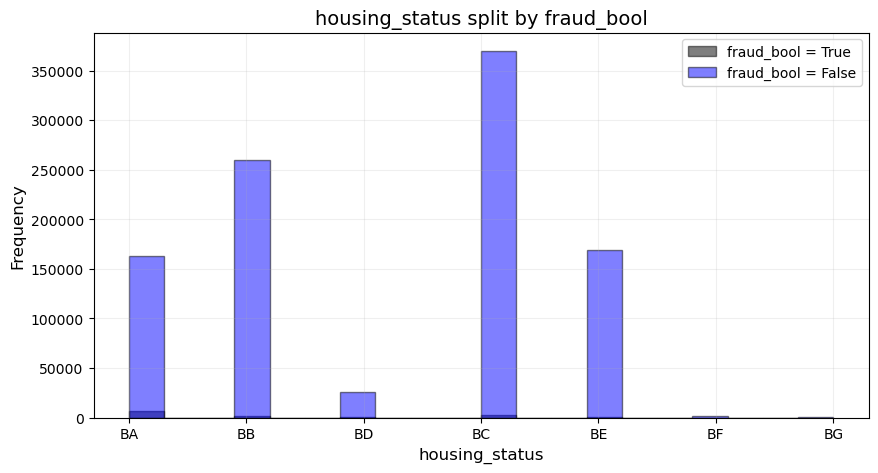

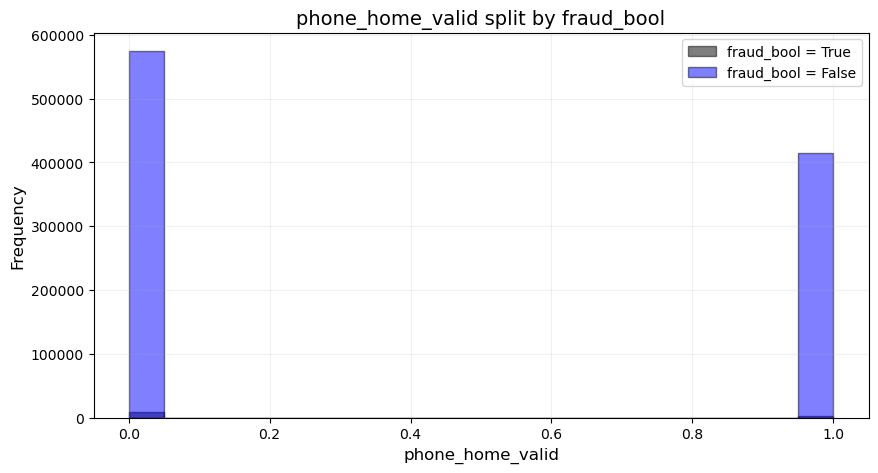

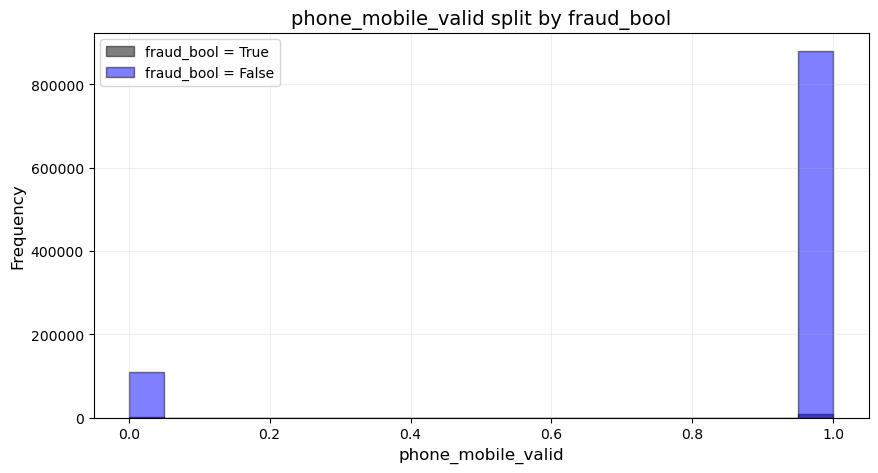

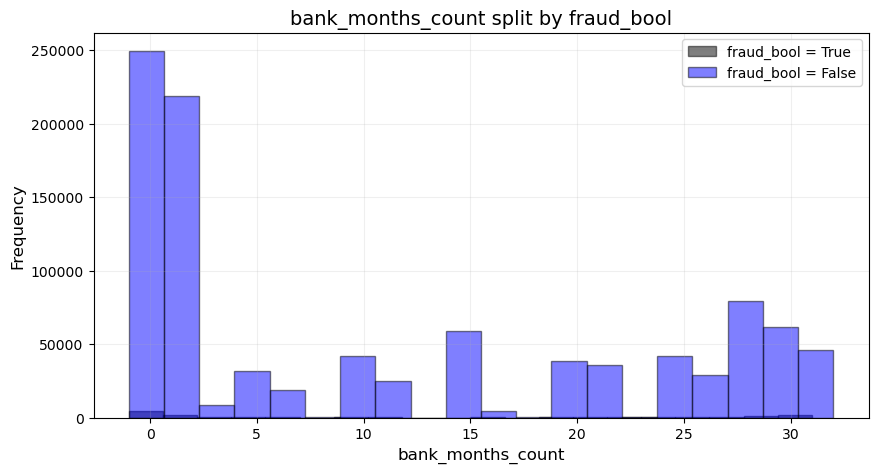

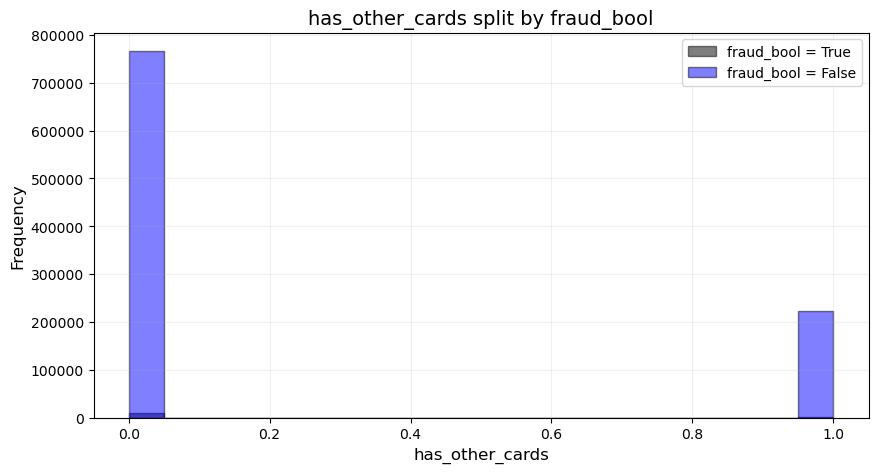

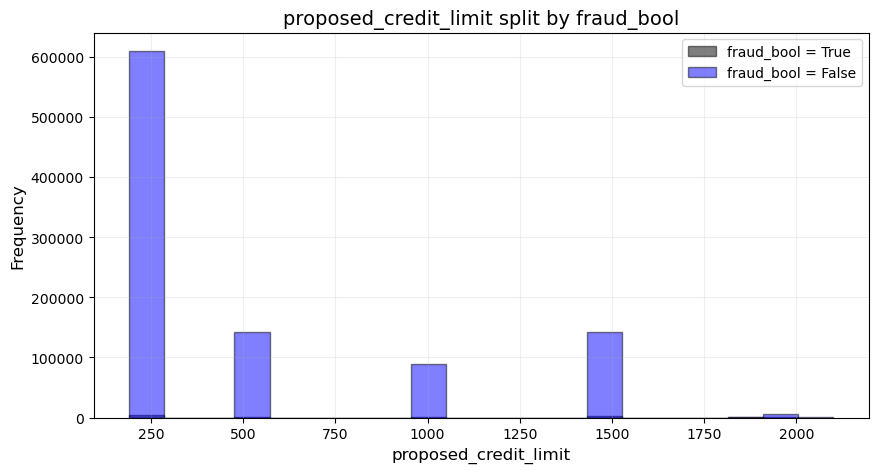

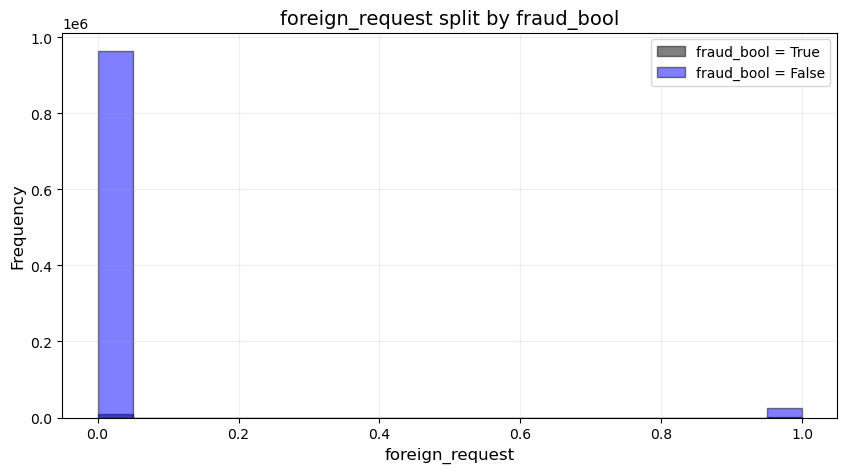

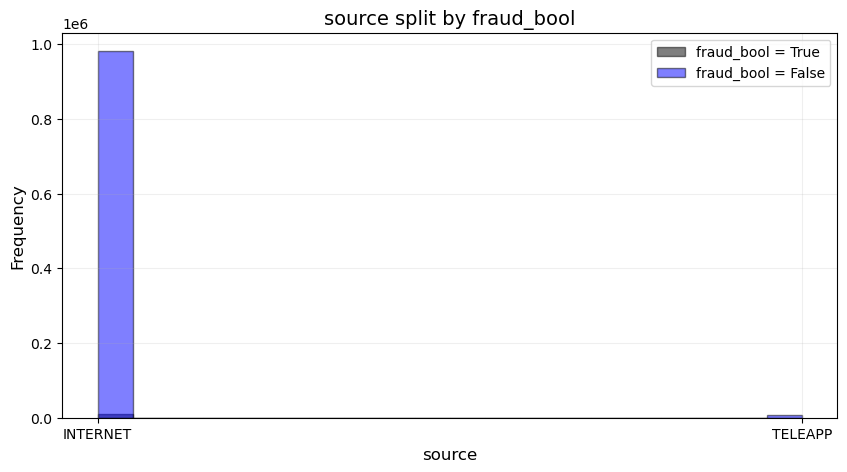

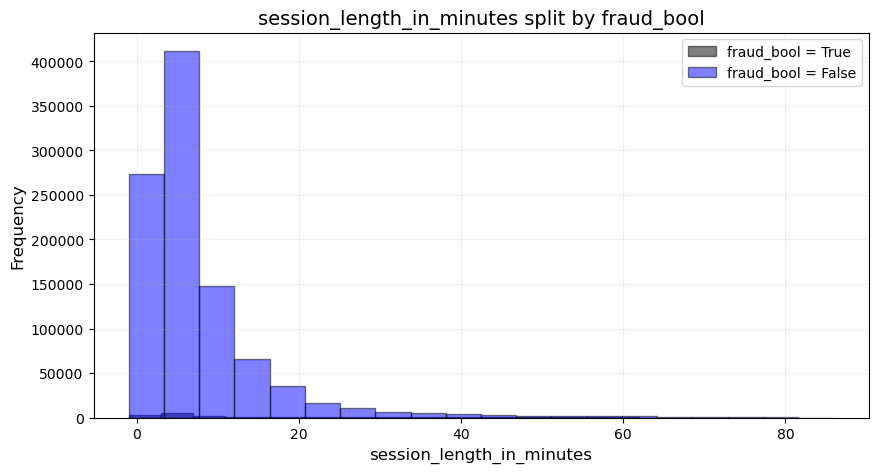

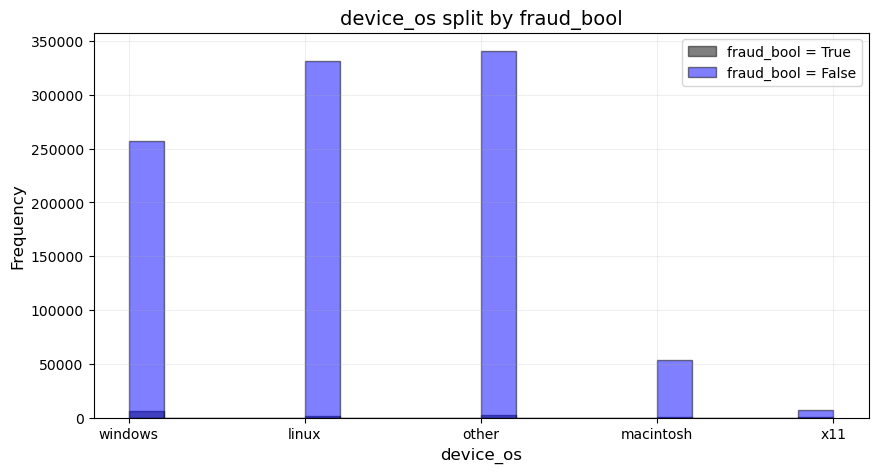

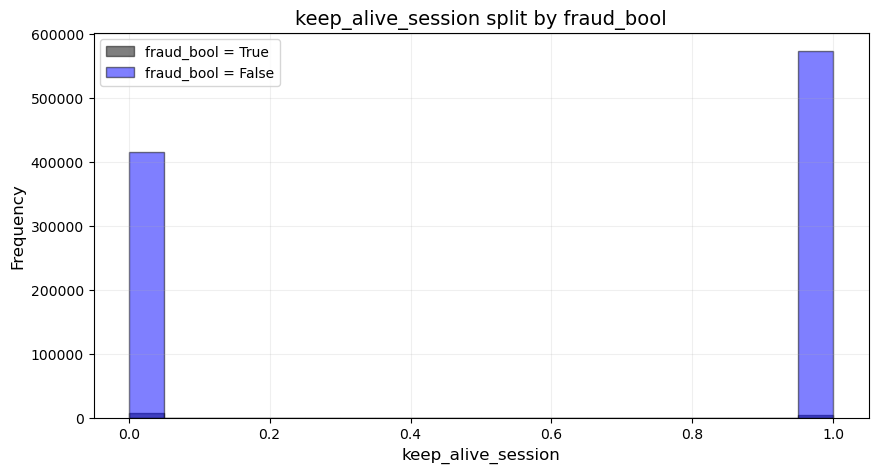

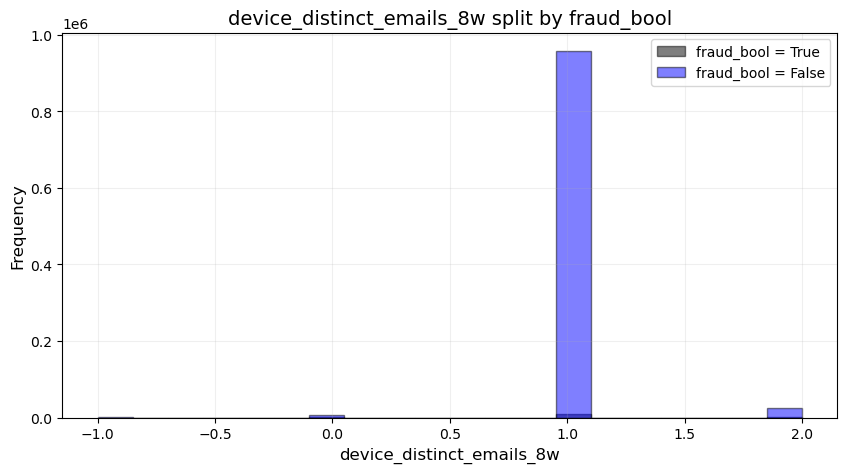

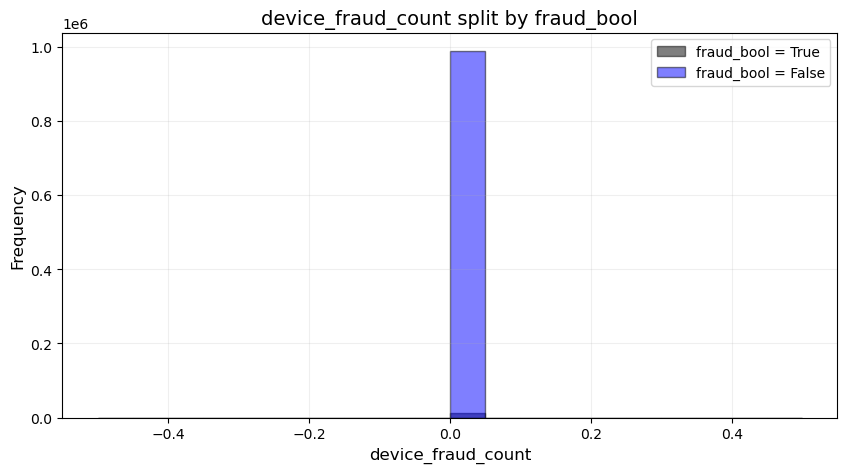

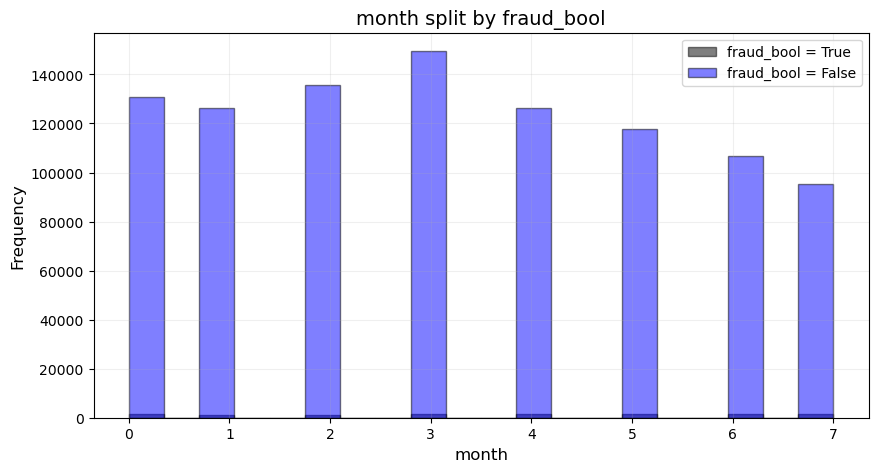

In [5]:
# In Naive Bayes, we need all vairables to either be in categorical or continuous forms, so let's go ahead and 
# Make histograms and bar plots to determine how we are going to split the continuous variables into categorical ones
# Also, we included all variables here just to have an idea of the distribution for each variable as well

# # Select only numerical columns
# numerical_columns = base.select_dtypes(include='number').columns

# # Omitt binary classifiers from list
# numerical_columns = [col for col in numerical_columns if col != 'fraud_bool']

# Create Histograms split on Fraud_bool for comparison
for column in base.columns:
    plt.figure(figsize=(10, 5))
    
    # Subset the data for fraud_bool == True
    base[base['fraud_bool'] == True][column].hist(
        bins=20, alpha=0.5, label='fraud_bool = True', edgecolor='black', color='black'
    )
    
    # Subset the data for fraud_bool == False
    base[base['fraud_bool'] == False][column].hist(
        bins=20, alpha=0.5, label='fraud_bool = False', edgecolor='black', color='blue'
    )
    
    # Set titles and labels
    plt.title(f"{column} split by fraud_bool", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

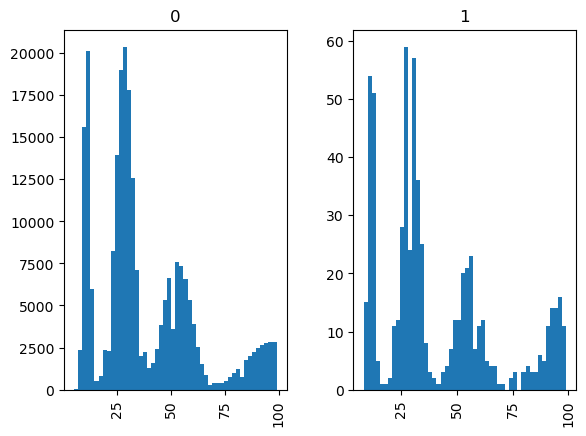

In [8]:
# Previous Address Months Count
# This has a pretty big range, so a transformation or more bins would be better
temp = base[(base["prev_address_months_count"] < 100) & (base["prev_address_months_count"] >= 0)]
temp.hist(column="prev_address_months_count", by="fraud_bool", bins=50)

In [9]:
# Convert Numerical predictors to categorical ones based on feature's quartiles
# NOTE: Future data will require this to be recalculated, and probs isn't best for prod-model
def convert_to_quartiles(df, feature):
    # Calculate quartiles
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.50)
    q3 = df[feature].quantile(0.75)
    
    # Bin the data based on quartile ranges
    bins = [-float('inf'), q1, q2, q3, float('inf')]
    # these labels will more than likely need updated 
    labels = ["low", "med-low", "med-high", "high"]
    
    # Remove duplicate bins and adjust labels
    unique_bins = list(sorted(set(bins)))  # Ensure bins are unique and sorted
    
    # Assign integer labels to each bin
    # Labels will always be [0, 1, 2, ..., n_bins - 2]
    quartile_series = pd.cut(df[feature], bins=unique_bins, labels=False, include_lowest=True)
    
    # Ensure integer type for compatibility with CategoricalNB
    return quartile_series.astype(int)

In [10]:
# Here, we are going to drop month, as I believe it shows data captured within an 8 month span, so its not helpful here
base.drop(columns=["month"], inplace=True)

In [11]:
# First, create list of all binary variables to use to exclude from numeric list
binary_classifiers = ["Fraud_bool", "email_is_free", "phone_home_valid", "phone_mobile_valid",
                      "has_other_cards", "foreign_request", "keep_alive_session"]

# Create list of numerical features all in binary_classifier list
numerical_cols = [col for col in base.select_dtypes(include='number').columns if col not in binary_classifiers]
numerical_cols = [col for col in base.select_dtypes(include='number').columns if col not in binary_classifiers]
# Create new binned df containing only the columns NOT in the numerical_cols list
binned_df = base.drop(columns=numerical_cols)

# Convert remaining numerical columns to be categorical features based on quantiles
for col in numerical_cols:
    binned_df[col] = convert_to_quartiles(base, col)

# Final dataframe should have same dim as base (remembering of course we excluded month)
print("Shape of base df: " + str(base.shape))
print("Shape of binned df: " + str(binned_df.shape))

Shape of base df: (1000000, 31)
Shape of binned df: (1000000, 31)


In [12]:
# Collect all normal categorical variables (non-binary/boolean)
categorical_vars = ["payment_type", "employment_status", "housing_status", "source", "device_os"]

# Initialize Label Encoder object
le = LabelEncoder()

# Use Integer Encoding to convert the other categorical variables to be integer-based too 
for col in categorical_vars:
    binned_df[col] = le.fit_transform(binned_df[col])

In [17]:
# Create Train and Test data
# Implement K-fold Cross-Validation and SMOTE oversampling to create train set with a lot of fraud cases

# First, split features from predicitor series
X = binned_df.drop("fraud_bool",axis=1)
y = base["fraud_bool"]

# Initialize the SMOTE instance for over-sampling
smote = SMOTE(sampling_strategy='auto', random_state=5525)

# Initialize the Naive Bayes classifier
nb = CategoricalNB()

# Create a pipeline with SMOTE and Naive Bayes
pipeline = Pipeline([('smote', smote), ('naive_bayes', nb)])

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5525)

# Initialize performance metrics storage bins
accuracy_list = []
precision_list = []
f1_score_list = []
all_y_true = []
all_y_pred_proba = []
fold_auc_scores = []
agg_conf_matrix = np.zeros((2, 2), dtype=int) #for confusion matrix

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model using the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate and store key performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fold_auc = roc_auc_score(y_test, y_pred_proba)
    fold_conf_matrix = confusion_matrix(y_test, y_pred)

    # Store and Update current fold's performance metrics
    accuracy_list.append(accuracy)
    f1_score_list.append(f1_metric)
    precision_list.append(precision)
    fold_auc_scores.append(fold_auc)
    agg_conf_matrix += fold_conf_matrix
    all_y_true.extend(y_test)
    all_y_pred_proba.extend(y_pred_proba)

In [18]:
# Results
print("Average Prediction Accuracy: " + str(np.mean(accuracy_list)))
print("Average F1 Score: " + str(np.mean(f1_score_list)))
print("Average Precision: " + str(np.mean(precision_list)))

Average Prediction Accuracy: 0.8523499999999998
Average F1 Score: 0.08936580587680529
Average Precision: 0.047944118240726204


In [19]:
# Calculate ROC, AUC, and Confusion Matrix Results
mean_auc = np.mean(fold_auc_scores)
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_proba)

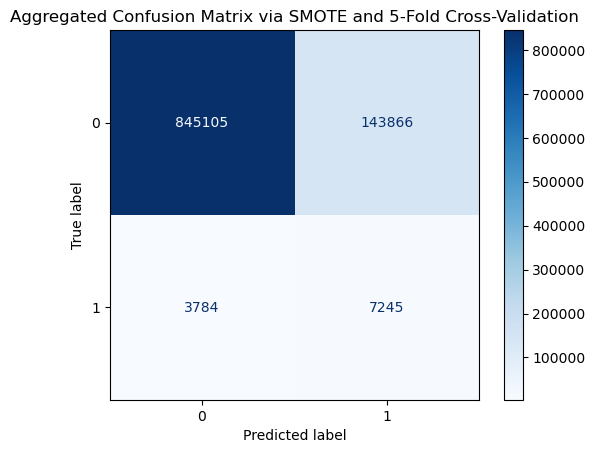

In [20]:
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=agg_conf_matrix,
                              display_labels=pipeline.named_steps['naive_bayes'].classes_)
disp.plot(cmap="Blues")
plt.title("Aggregated Confusion Matrix via SMOTE and 5-Fold Cross-Validation")
plt.show()

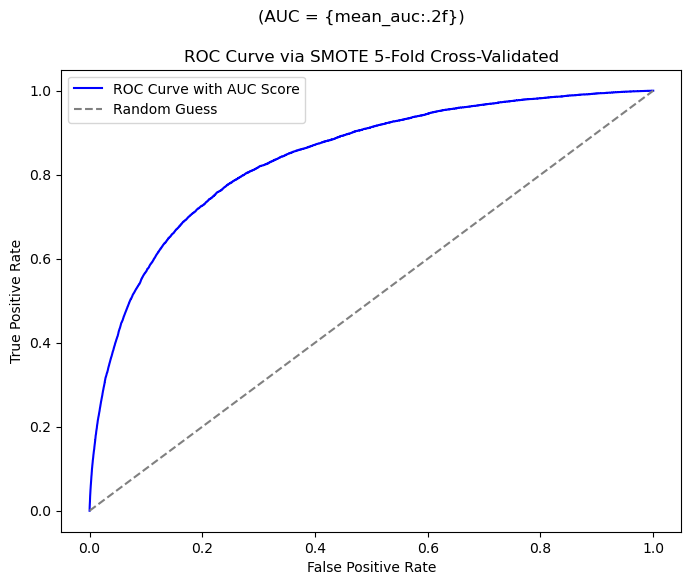

In [21]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve with AUC Score", color='blue')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("ROC Curve via SMOTE 5-Fold Cross-Validated")
plt.suptitle("(AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Code above featured oversampling in NB Classifier, which far increased the probability of something to be labelled as 1 when it shouldn't of been, thus, giving us a very low precision score. Continue by removing the oversampling, and redeploy train model